In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic
from cohlib.plot import draw_raster_single

In [2]:
def plot_synthetic_data(L, sample_length, C, seed, alpha, fs=1000, start=0):
    T = sample_length/fs
    trange = [0,T]
    data_path = f'saved/synthetic_data/simple_synthetic_nodc_2_{L}_{sample_length}_{C}_{alpha}_{seed}'

    data_load = pickle_open(data_path)

    spikes = data_load['observed']['spikes']

    Gamma = data_load['latent']['Gamma']
    xs = data_load['latent']['xs']
    vs = data_load['latent']['vs']
    zs = data_load['latent']['zs']
    lams = data_load['observed']['lams']

    freqs = data_load['meta']['freqs']

    swap = False
    ls = [0,1,2]
    fig,ax = plt.subplots(6,1,figsize=(12,7), sharex=True)
    ls = [l + start for l in ls]
    title_size = 16
    label_size = 14
    x = np.arange(0, sample_length) / 1000
    # for i in range(start,start+3):
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    for i, l in enumerate(ls):
    # i = 3
        
        ax[0].plot(x, xs[l,0,:], color=colors[i])
        # ax[0].set_ylim([-1,1])
        ax[0].margins(0)
        ax[0].set_title(r'$x_t^{1, \ell}$  $\ell = (1,2,3)$', size=title_size)
        ax[0].set_ylabel('mV', size = label_size)

        ax[1].plot(x, xs[l,1,:], color=colors[i])
        # ax[1].set_ylim([-1,1])
        ax[1].margins(0)
        ax[1].set_title(r'$x_t^{2, \ell}$  $\ell = (1,2,3)$', size=title_size)
        ax[1].set_ylabel('mV', size = label_size)

        ax[2].plot(x, lams[l,0,:], color=colors[i])
        ax[2].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
        ax[2].margins(0)
        ax[2].set_ylabel('Intensity', size = label_size)

        ax[3].plot(x, lams[l,1,:], color=colors[i])
        ax[3].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
        ax[3].margins(0)
        ax[3].set_ylabel('Intensity', size = label_size)

    # draw_raster_single(spikes[start,:,:], trange=[0,0.5], region='CPB', override_bg_color='white',ax=ax[3])
    color = colors[0]
    spike_matA = spikes[ls[0],:,0,:]
    spike_matB = spikes[ls[0],:,1,:]
    draw_raster_single(spike_matA, trange=trange, color_name=color, ax=ax[4])
    draw_raster_single(spike_matB, trange=trange, color_name=color, ax=ax[5])
    ax[4].set_title(r'$n_t^{1, c,\ell}$   $c = (1, ..., C)$   $\ell = 1$', size=title_size)
    ax[5].set_title(r'$n_t^{2, c,\ell}$   $c = (1, ..., C)$   $\ell = 1$', size=title_size)
    ax[4].set_ylabel('Spikes A', size = label_size)
    ax[5].set_ylabel('Spikes B', size = label_size)

    ax[5].set_xlabel('Time (sec)', size = label_size)
    plt.xlim([0,sample_length/fs])
    plt.tight_layout()

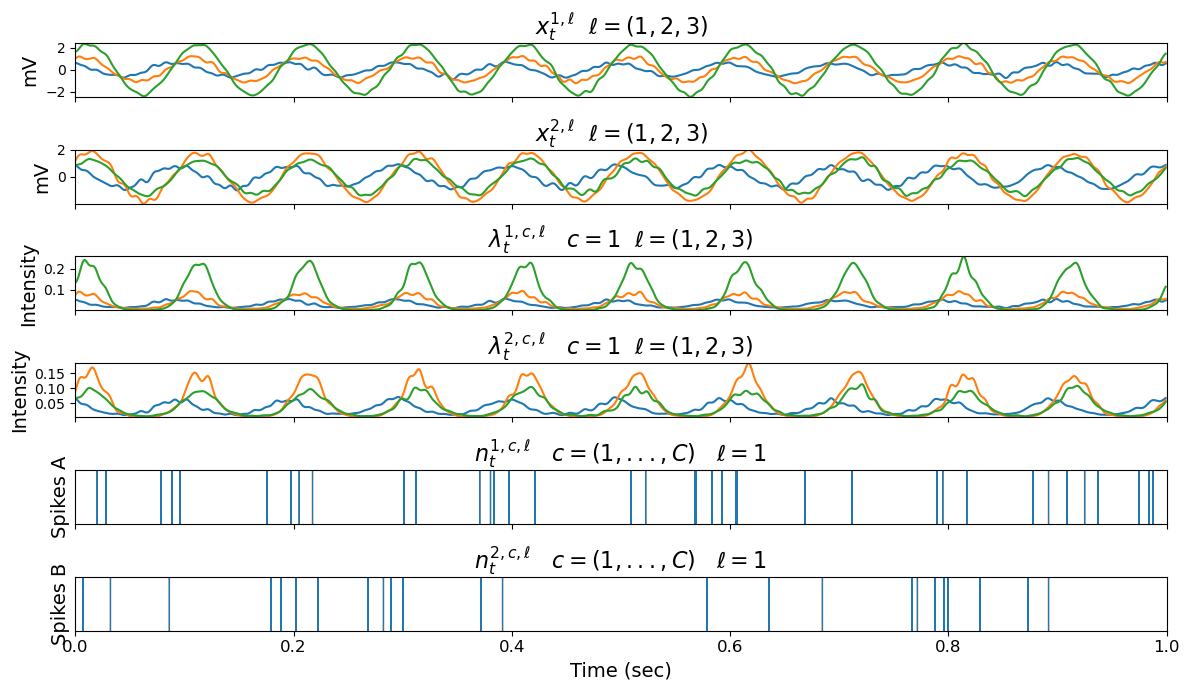

In [3]:
alpha = -3.5
K = 2
L = 25 
C = 1
sample_length = 1000
seed = 7
plot_synthetic_data(L, sample_length, C, seed, alpha, 
start=3)



In [12]:
from numpy.fft import rfft
def load_and_calc(func, K, L, sample_length, C, alpha, J_max):
    data_path = f'saved/synthetic_data/simple_synthetic_nodc_{K}_{L}_{sample_length}_1_-3.5_7'
    data_load = pickle_open(data_path)

    model_path = f'saved/fitted_models/simple_synthetic_dc_em{num_em}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_fitted'
    model_load = pickle_open(model_path)
    print(f'{K} {L} {C} {alpha}')

    Gamma_true = data_load['latent']['Gamma']
    zs = data_load['latent']['zs']
    Wv_data = data_load['meta']['Wv']
    freqs = data_load['meta']['freqs']

    Wv_model = model_load['Wv']
    Wv = Wv_model
    freqs_mod = freqs[:int((Wv.shape[1]) / 2)]
    spikes_Cavg = model_load['spikes_Cavg']

    J = int((Wv.shape[1])/2)

    # ys_ft = rfft(ys, axis=3).mean(1)
    # ys_ft_outer = np.einsum('lmj,lnj->jmnl', ys_ft,ys_ft.conj())
    # naive = ys_ft_outer.mean(3)
    spikes_ft = rfft(spikes_Cavg - spikes_Cavg.mean(2)[:,:,None], axis=2)
    spikes_ft_outer = np.einsum('lmj,lnj->jmnl', spikes_ft,spikes_ft.conj())
    naive = spikes_ft_outer.mean(3)
    # naive = naive/1000

    # func_true = func(Gamma_true[:J_max,:,:])
    func_true = func(Gamma_true[:J_max,:,:])
    func_naive = func(naive[1:J_max+1,:,:])
    model_est = model_load['Gamma']
    func_model = func(model_est)

    direct_est = Gamma_est_from_zs(zs[:,:,:J_max])
    func_zs = func(direct_est)

    return func_true, func_zs, func_model, func_naive

In [18]:
def get_power1(Gamma):
    return Gamma[:,0,0].real

def get_power1dB(Gamma):
    return 10*np.log10(Gamma[:,0,0].real)

from cohlib.utils import conv_v_to_z
def Gamma_est_from_zs(zs, dc=False):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean

In [13]:
num_em = 10
seed = 8
alpha = -3.0
data_path = f'saved/synthetic_data/simple_synthetic_nodc_{K}_{L}_{sample_length}_1_-3.5_7'
model_path = f'saved/fitted_models/simple_synthetic_dc_em{num_em}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_fitted'

data_load = pickle_open(data_path)
model_load = pickle_open(model_path)
Gamma = data_load['latent']['Gamma']
zs = data_load['latent']['zs']
spikes_Cavg = model_load['spikes_Cavg']

freqs = data_load['meta']['freqs']

Wv_model = model_load['Wv']
Wv = Wv_model
freqs_mod = freqs[:int((Wv.shape[1]) / 2)]

J_max = int(((Wv.shape[1])/2))


In [17]:
zs.shape

(25, 2, 500)

In [19]:
Cs = [1, 5, 10, 25]
alphas = [-5.0, -4.0, -3.0, -2.0, -1.0]

num_groups = K
num_trials = L

o1 = 1.0
power1s = np.zeros((len(Cs), len(alphas), 4, J_max))
power1dBs = np.zeros((len(Cs), len(alphas), 4, J_max))
for c, num_neurons in enumerate(Cs):
    for i2, alpha in enumerate(alphas):
        power1_true, power1_zs, power1_model, power1_naive = load_and_calc(get_power1, num_groups, num_trials, 1000, num_neurons, alpha, J_max)
        power1s[c,i2,0,:] = power1_true
        power1s[c,i2,1,:] = power1_zs
        power1s[c,i2,2,:] = power1_model
        power1s[c,i2,3,:] = power1_naive * (2*np.pi)**2

        power1dBs[c,i2,0,:] = 10*np.log10(power1_true)
        power1dBs[c,i2,1,:] = 10*np.log10(power1_zs)
        power1dBs[c,i2,2,:] = 10*np.log10(power1_model)
        power1dBs[c,i2,3,:] = 10*np.log10(power1_naive * (2*np.pi)**2)

2 25 1 -5.0
2 25 1 -4.0
2 25 1 -3.0
2 25 1 -2.0
2 25 1 -1.0
2 25 5 -5.0
2 25 5 -4.0
2 25 5 -3.0
2 25 5 -2.0
2 25 5 -1.0
2 25 10 -5.0
2 25 10 -4.0
2 25 10 -3.0
2 25 10 -2.0
2 25 10 -1.0
2 25 25 -5.0
2 25 25 -4.0
2 25 25 -3.0
2 25 25 -2.0
2 25 25 -1.0


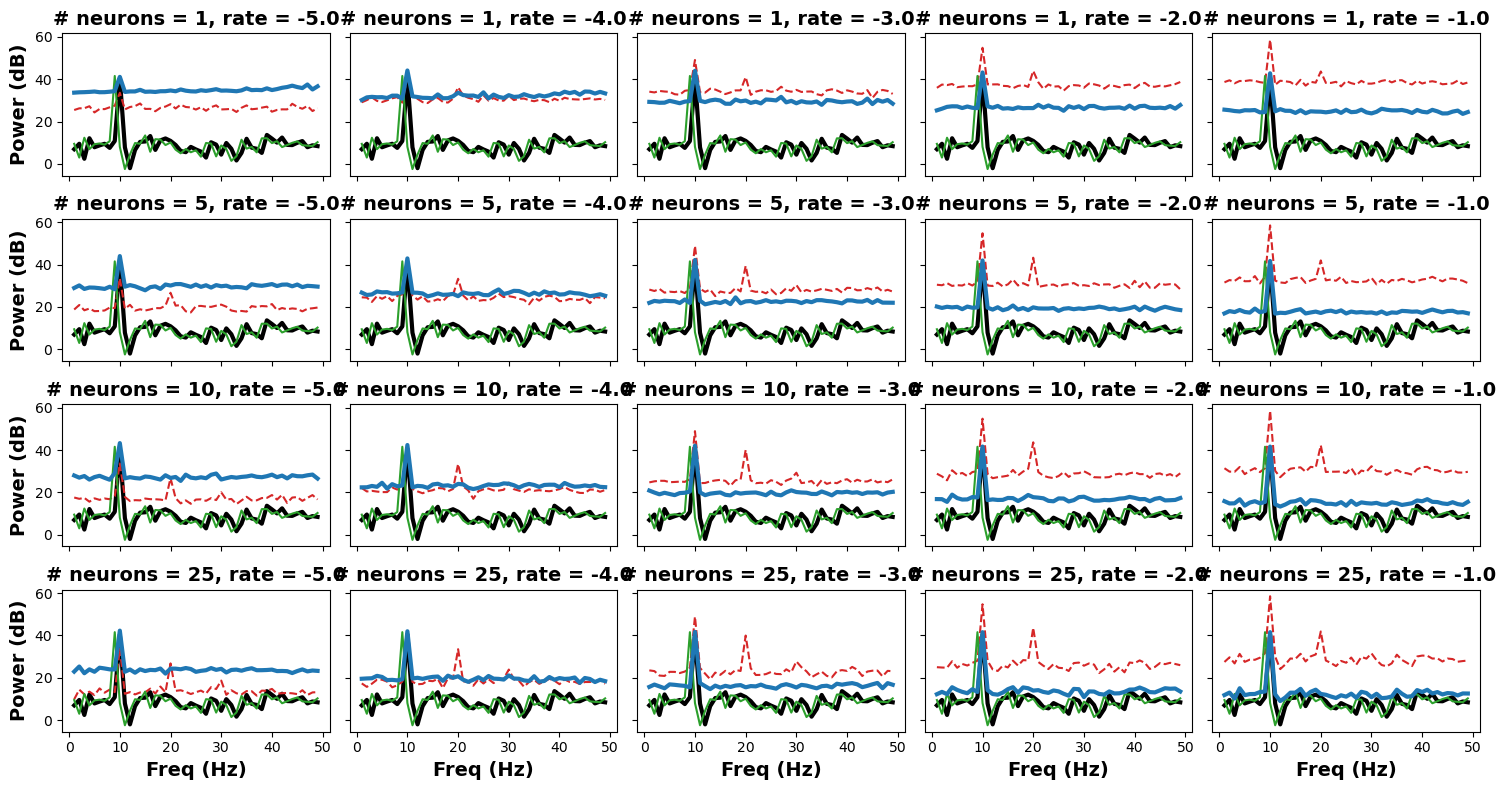

In [12]:
plot_power1dB_ov_c()

In [ ]:
# offset for z, what's going on there???
# resimulate so that 'floor' for true / z is 1 for log except for freq 10...

# HAVE TO FIGURE OUT NAIVE SCALING
# oh wait wow, fix above and replot... then run same settings with DC 
# I think we're seeing that we have a biased estimator, but but it looks like it's not a function of the mean rate???
# something very weird is happening, red seems correct, but blue as function of rate is very weird... moving in opposite direction!!!
# sleep on this and proceed very slowly and deliberately
# could also be worth trying gaussian with no DC and see if anything changes



In [96]:
from numpy.fft import rfft

def plot_power1_ov_c():
    fig, ax = plt.subplots(4,5, figsize=(15,8), sharex=True, sharey=True)
    for i1 in range(len(Cs)):
        for i2 in range(len(alphas)):
            power1_true = power1s[i1,i2,0,:] 
            power1_zs = power1s[i1,i2,1,:] 
            power1_model = power1s[i1,i2,2,:] 
            power1_naive = power1s[i1,i2,3,:] 

            ax[i1,i2].plot(freqs_mod, power1_true, color='k', label='true', linewidth=3)
            ax[i1,i2].plot(freqs_mod, power1_zs, color='tab:green', label='direct')
            ax[i1,i2].plot(freqs_mod, power1_model, color='tab:blue', linewidth=3, label='model')
            ax[i1,i2].plot(freqs_mod, power1_naive, linestyle='--', color='tab:red', label='naive')

            ax[i1,i2].set_title(f'# neurons = {Cs[i1]}, rate = {alphas[i2]}', fontweight='bold', fontsize=14)
            if i2 == 0:
                ax[i1,i2].set_ylabel(f'Power', fontweight='bold', fontsize=14)
            if i1 == len(Cs)-1:
                ax[i1,i2].set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
    plt.tight_layout()

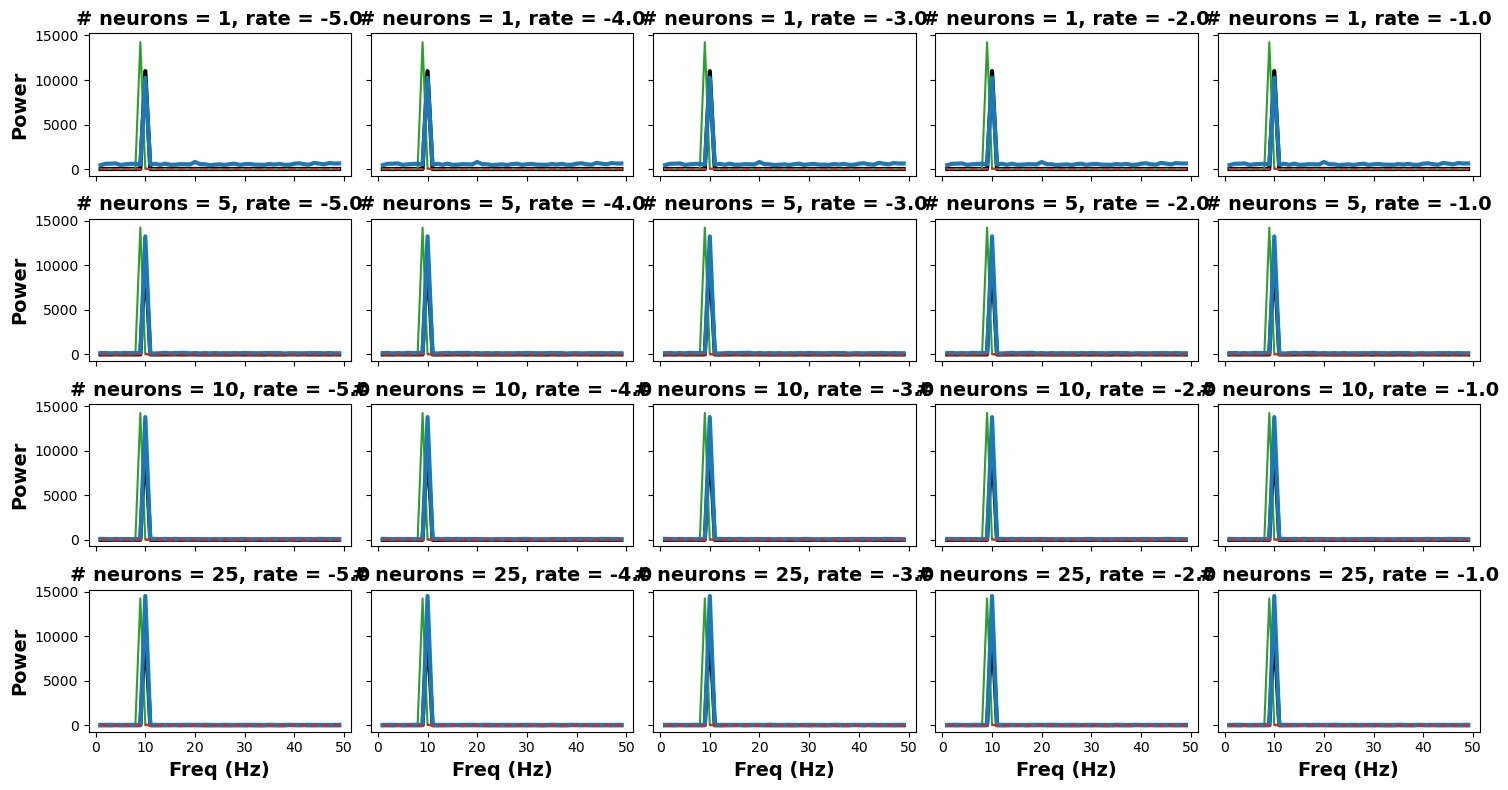

In [90]:
# approx
plot_power1_ov_c()

In [22]:
num_em = 10
from numpy.fft import rfft

def plot_power1dB_ov_c():
    fig, ax = plt.subplots(4,5, figsize=(15,8), sharex=True, sharey=True)
    for i1 in range(len(Cs)):
        for i2 in range(len(alphas)):
            power1dB_true = power1dBs[i1,i2,0,:] 
            power1dB_zs = power1dBs[i1,i2,1,:] 
            power1dB_model = power1dBs[i1,i2,2,:] 
            power1dB_naive = power1dBs[i1,i2,3,:] 

            ax[i1,i2].plot(freqs_mod, power1dB_true, color='k', label='true', linewidth=3)
            ax[i1,i2].plot(freqs_mod, power1dB_naive, linestyle='--', color='tab:red', label='naive')
            ax[i1,i2].plot(freqs_mod, power1dB_zs, color='tab:green', label='direct')
            ax[i1,i2].plot(freqs_mod, power1dB_model, color='tab:blue', linewidth=3, label='model')

            ax[i1,i2].set_title(f'C = {Cs[i1]}, ' + r'$\mathbf{\alpha}$' + f' = {alphas[i2]}', fontweight='bold', fontsize=14)
            if i2 == 0:
                ax[i1,i2].set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
            if i1 == len(Cs)-1:
                ax[i1,i2].set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
    plt.tight_layout()

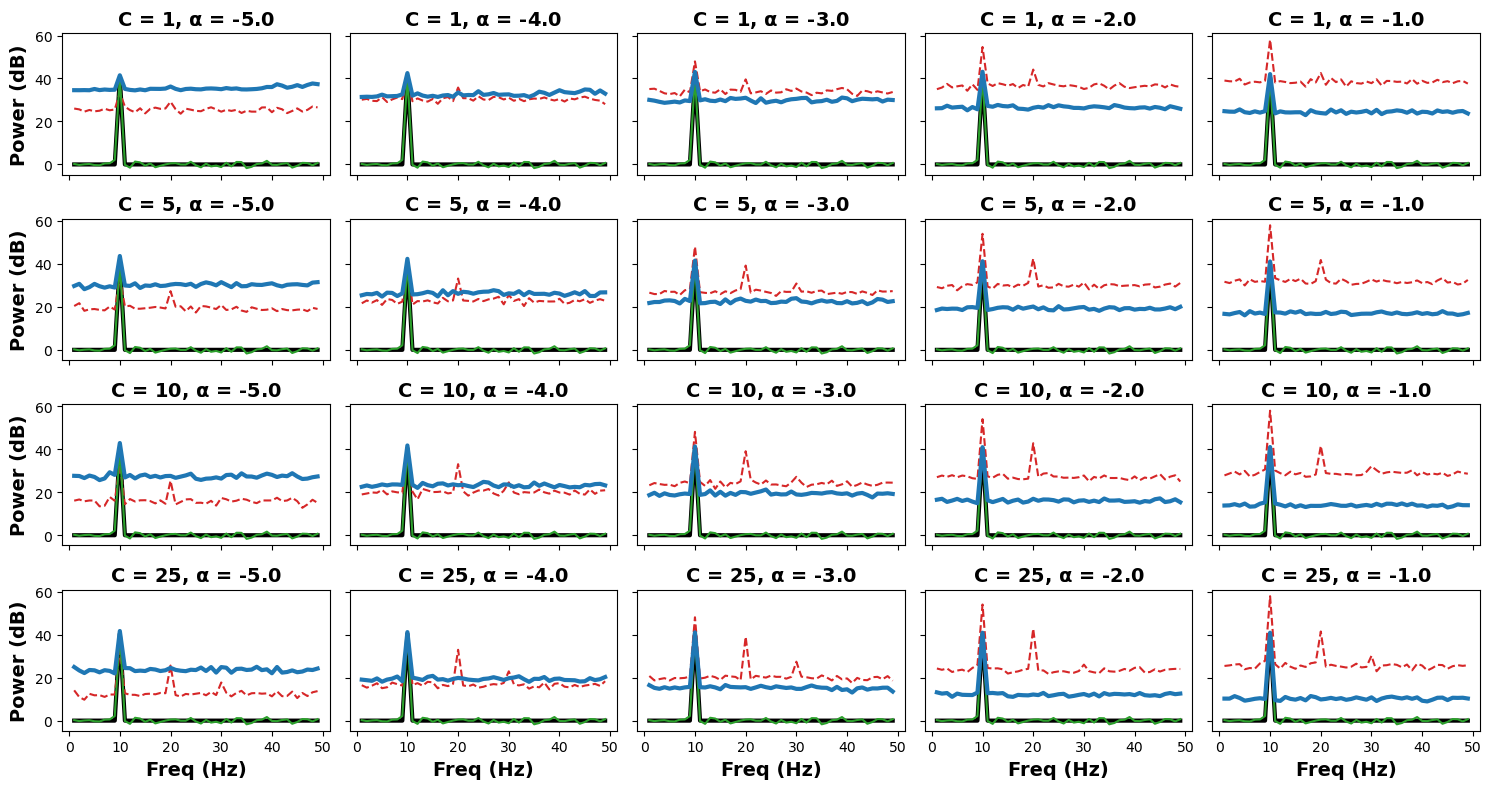

In [23]:
#approx
plot_power1dB_ov_c()

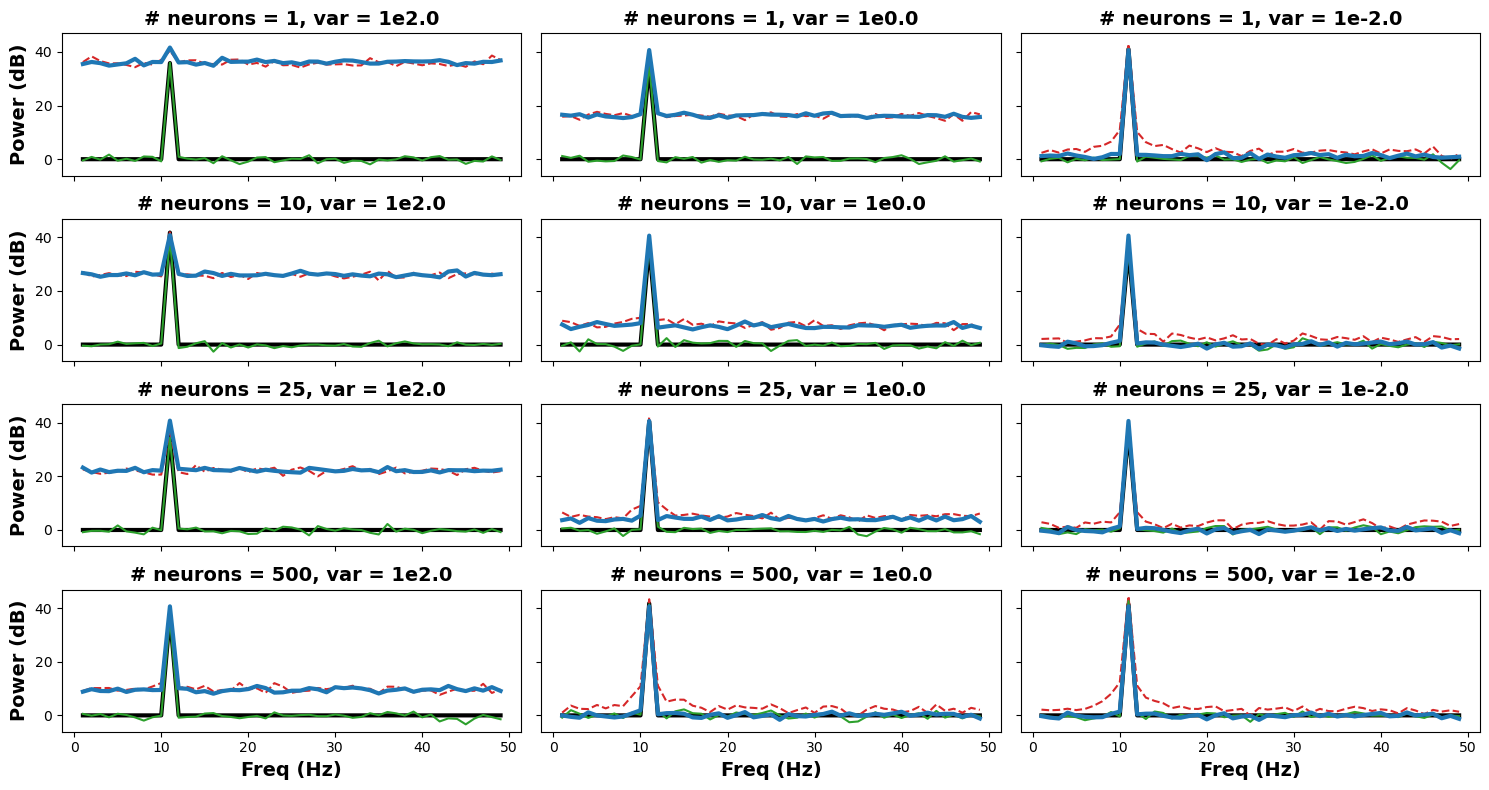

In [18]:
plot_power1dB_ov_c()